Copyright 2021 The TensorFlow Hub Authors.
Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2021 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Transfer Learning for the Audio Domain with Model Maker

In this notebook, you'll learn how to use Model Maker for the Audio Domain.

It is part of the [Codelab to Customize an Audio model and deploy on Android](https://codelabs.developers.google.com/codelabs/tflite-audio-classification-custom-model-android).

You'll use a custom birds dataset and export a TFLite model that can be used on a phone, a TensorFlow.JS model that can be used for inference in the browser and also a SavedModel version that you can use for serving.



## Intalling dependencies

Model Maker for the Audio domain needs TensorFlow 2.5 to work.

In [9]:
! pip install tflite_model_maker

  Using cached tflite_model_maker-0.3.4-py3-none-any.whl (616 kB)
  Using cached tensorflow_model_optimization-0.7.2-py2.py3-none-any.whl (237 kB)
  Using cached tf_models_official-2.3.0-py2.py3-none-any.whl (840 kB)
  Using cached fire-0.4.0-py2.py3-none-any.whl
  Using cached neural_structured_learning-1.3.1-py2.py3-none-any.whl (120 kB)
  Using cached tensorflow_datasets-4.5.2-py3-none-any.whl (4.2 MB)
  Using cached tensorflowjs-3.14.0-py3-none-any.whl (77 kB)
  Using cached librosa-0.8.1-py3-none-any.whl (203 kB)
  Using cached numba-0.53.0-cp37-cp37m-win_amd64.whl (2.3 MB)
  Using cached tflite_support-0.3.1-cp37-cp37m-win_amd64.whl (427 kB)
  Using cached llvmlite-0.36.0-cp37-cp37m-win_amd64.whl (16.0 MB)
  Using cached tf_slim-1.1.0-py2.py3-none-any.whl (352 kB)
  Using cached google_cloud_bigquery-2.34.2-py2.py3-none-any.whl (206 kB)
  Using cached kaggle-1.5.12-py3-none-any.whl
  Using cached keras-2.7.0-py2.py3-none-any.whl (1.3 MB)
  Using cached tensorflow_metadata-1.7.0-p

ERROR: Cannot uninstall 'llvmlite'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.


In [3]:
!pip list

Package                            Version
---------------------------------- -------------------
absl-py                            0.12.0
alabaster                          0.7.12
anaconda-client                    1.7.2
anaconda-navigator                 1.10.0
anaconda-project                   0.8.3
appdirs                            1.4.4
asn1crypto                         1.0.1
ast-scope                          0.3.1
astroid                            2.3.1
astropy                            3.2.1
astunparse                         1.6.3
atomicwrites                       1.3.0
attrs                              19.3.0
audioread                          2.1.9
Automat                            20.2.0
Babel                              2.7.0
backcall                           0.1.0
backports.entry-points-selectable  1.1.1
backports.functools-lru-cache      1.6.1
backports.os                       0.1.1
backports.shutil-get-terminal-size 1.0.0
backports.tempfile                 1

## Import TensorFlow, Model Maker and other libraries

Among the dependencies that are needed, you'll use TensorFlow and Model Maker. Aside those, the others are for audio manipulation, playing and visualizations.

In [11]:
from sklearn.metrics import cohen_kappa_score

In [1]:
import tensorflow as tf
import tflite_model_maker as mm
from tflite_model_maker import audio_classifier
import sklearn.metrics.cohen_kappa_score as cks
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import glob
import random

from IPython.display import Audio, Image
from scipy.io import wavfile

print(f"TensorFlow Version: {tf.__version__}")
print(f"Model Maker Version: {mm.__version__}")

C:\Users\basti\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\Users\basti\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

TensorFlow Version: 2.7.0
Model Maker Version: 0.3.4


In [3]:
import os
import wave
dir_fd = os.open('.', os.O_RDONLY)

with wave.open('\\201104270459.wav', 'rb') as f:
    frame_rate = f.getframerate()
    print(frame_rate)

# for file_name in os.listdir('2'):
#     with wave.open(file_name, "rb") as wave_file:
#         frame_rate = wave_file.getframerate()
#         print(frame_rate)

PermissionError: [Errno 13] Permission denied: '.'

## The Birds dataset

The Birds dataset is an education collection of 5 types of birds songs:

- White-breasted Wood-Wren
- House Sparrow
- Red Crossbill  
- Chestnut-crowned Antpitta
- Azara's Spinetail

The original audio came from [Xeno-canto](https://www.xeno-canto.org/) which is a website dedicated to sharing bird sounds from all over the world.

Let's start by downloading the data.

In [4]:
# birds_dataset_folder = tf.keras.utils.get_file('birds_dataset.zip',
#                                                 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/birds_dataset.zip',
#                                                 cache_dir='./',
#                                                 cache_subdir='dataset',
#                                                 extract=True)
                                                

## Explore the data

The audios are already split in train and test folders. Inside each split folder, there's one folder for each bird, using their `bird_code` as name.

The audios are all mono and with 16kHz sample rate.

For more information about each file, you can read the `metadata.csv` file. It contains all the files authors, lincenses and some more information. You won't need to read it yourself on this tutorial.

In [2]:
# @title [Run this] Util functions and data structures.

data_dir = '.\\Data\\Train\\'

# data_dir = './dataset/small_birds_dataset'

heart_sound_code_to_name = {
  'Artifact': 'Artifact, noise',
  'Extrahs': 'Extra heart sound',
  'Murmur': 'Murmur',  
  'Normal': 'Normal heartbeat',
  'Extrasystole': 'Extrasystole',
}


test_files = os.path.join(data_dir, 'val\\*\\*.wav')

# test_files = 'training/*/*.wav'


# bird_code = audio_path.split('/')[1]


def get_random_audio_file():
  test_list = glob.glob(test_files)
  random_audio_path = random.choice(test_list)
  return random_audio_path


def show_heart_data(audio_path):
  sample_rate, audio_data = wavfile.read(audio_path, 'rb')
  # print(audio_path, 'HERE')
  heart_sound_code = audio_path.split('\\')[-2]
  # print(bird_code)
  print(f'heart sound name: {heart_sound_code_to_name[heart_sound_code]}')
  print(f'heart sound code: {heart_sound_code}')
  # display(Image(birds_images[bird_code]))

  plttitle = f'{heart_sound_code_to_name[heart_sound_code]} ({heart_sound_code})'
  plt.title(plttitle)
  plt.plot(audio_data)
  # display(Audio(audio_data, rate=sample_rate))

print('functions and data structures created')

functions and data structures created


### Playing some audio

To have a better understanding about the data, lets listen to a random audio files from the test split.

Note: later in this notebook you'll run inference on this audio for testing

heart sound name: Murmur
heart sound code: Murmur


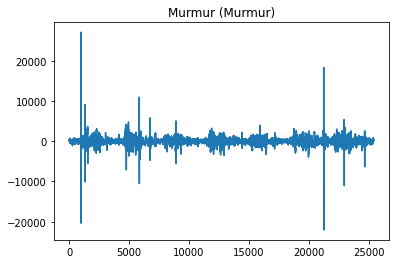

In [5]:
random_audio = get_random_audio_file()
show_heart_data(random_audio)

# Training the model


In [6]:
spec = audio_classifier.YamNetSpec(keep_yamnet_and_custom_heads=True, frame_step=3 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH,frame_length=6 * audio_classifier.YamNetSpec.EXPECTED_WAVEFORM_LENGTH)


INFO:tensorflow:Checkpoints are stored in C:\Users\basti\AppData\Local\Temp\tmpf80k8w8s


## Loading the data

In [7]:
train_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'train'), cache=True)

validation_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'val'), cache=True)


test_data = audio_classifier.DataLoader.from_folder(
    spec, os.path.join(data_dir, 'test'), cache=True)

## Training the model

the audio_classifier has the [`create`](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier/create) method that creates a model and already start training it. 

You can customize many parameterss, for more information you can read more details in the documentation.

On this first try you'll use all the default configurations and train for 100 epochs.

Note: The first epoch takes longer than all the other ones because it's when the cache is created. After that each epoch takes close to 1 second.

In [8]:
batch_size = 30
epochs = 400

print('Training the model')
model = audio_classifier.create(
    train_data,
    spec,
    validation_data,
    batch_size=batch_size,
    epochs=epochs)

Training the model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 classification_head (Dense)  (None, 4)                4100      
                                                                 
Total params: 4,100
Trainable params: 4,100
Non-trainable params: 0
_________________________________________________________________
Epoch 1/400
10/10 [==============================].3653 - acc: 0.366 - 7s 1s/step - loss: 1.3560 - acc: 0.350 - 9s 1s/step - loss: 1.3245 - acc: 0.388 - 10s 1s/step - loss: 1.3526 - acc: 0.36 - 12s 1s/step - loss: 1.3672 - acc: 0.31 - 13s 1s/step - loss: 1.3581 - acc: 0.30 - 13s 1s/step - loss: 1.3384 - acc: 0.30 - 18s 1s/step - loss: 1.3115 - acc: 0.3310 - val_loss: 1.1568 - val_acc: 0.4600
Epoch 2/400
10/10 [==============================] - ETA: 0s - loss: 1.0506 - acc: 0.466 - 0s 26ms/step - loss: 1.0794 - acc: 0.5552 - val_loss: 0.9595 - val_acc: 0.640

10/10 [==============================] - ETA: 0s - loss: 0.5166 - acc: 0.900 - 0s 26ms/step - loss: 0.4627 - acc: 0.8310 - val_loss: 0.4058 - val_acc: 0.8500
Epoch 45/400
10/10 [==============================] - ETA: 0s - loss: 0.3828 - acc: 0.900 - 0s 25ms/step - loss: 0.4446 - acc: 0.8517 - val_loss: 0.4026 - val_acc: 0.8500
Epoch 46/400
10/10 [==============================] - ETA: 0s - loss: 0.5303 - acc: 0.800 - 0s 25ms/step - loss: 0.4567 - acc: 0.8310 - val_loss: 0.4006 - val_acc: 0.8500
Epoch 47/400
10/10 [==============================] - ETA: 0s - loss: 0.4954 - acc: 0.866 - 0s 25ms/step - loss: 0.4487 - acc: 0.8379 - val_loss: 0.3986 - val_acc: 0.8500
Epoch 48/400
10/10 [==============================] - ETA: 0s - loss: 0.5217 - acc: 0.733 - 0s 26ms/step - loss: 0.4507 - acc: 0.8414 - val_loss: 0.3982 - val_acc: 0.8600
Epoch 49/400
10/10 [==============================] - ETA: 0s - loss: 0.5913 - acc: 0.766 - 0s 25ms/step - loss: 0.4381 - acc: 0.8414 - val_loss: 0.3964 - val

Epoch 92/400
10/10 [==============================] - ETA: 0s - loss: 0.4880 - acc: 0.833 - 0s 25ms/step - loss: 0.3736 - acc: 0.8621 - val_loss: 0.3526 - val_acc: 0.8700
Epoch 93/400
10/10 [==============================] - ETA: 0s - loss: 0.3963 - acc: 0.833 - 0s 25ms/step - loss: 0.3878 - acc: 0.8586 - val_loss: 0.3532 - val_acc: 0.8700
Epoch 94/400
10/10 [==============================] - ETA: 0s - loss: 0.3358 - acc: 0.866 - 0s 25ms/step - loss: 0.4036 - acc: 0.8655 - val_loss: 0.3521 - val_acc: 0.8700
Epoch 95/400
10/10 [==============================] - ETA: 0s - loss: 0.3381 - acc: 0.900 - 0s 26ms/step - loss: 0.3970 - acc: 0.8655 - val_loss: 0.3518 - val_acc: 0.8700
Epoch 96/400
10/10 [==============================] - ETA: 0s - loss: 0.5538 - acc: 0.766 - 0s 26ms/step - loss: 0.3526 - acc: 0.8862 - val_loss: 0.3512 - val_acc: 0.8700
Epoch 97/400
10/10 [==============================] - ETA: 0s - loss: 0.3299 - acc: 0.900 - 0s 25ms/step - loss: 0.3829 - acc: 0.8655 - val_loss:

Epoch 140/400
10/10 [==============================] - ETA: 0s - loss: 0.5254 - acc: 0.833 - 0s 25ms/step - loss: 0.3613 - acc: 0.8586 - val_loss: 0.3332 - val_acc: 0.8700
Epoch 141/400
10/10 [==============================] - ETA: 0s - loss: 0.3891 - acc: 0.866 - 0s 25ms/step - loss: 0.3810 - acc: 0.8586 - val_loss: 0.3320 - val_acc: 0.8700
Epoch 142/400
10/10 [==============================] - ETA: 0s - loss: 0.3244 - acc: 0.900 - 0s 25ms/step - loss: 0.3640 - acc: 0.8655 - val_loss: 0.3317 - val_acc: 0.8700
Epoch 143/400
10/10 [==============================] - ETA: 0s - loss: 0.3249 - acc: 0.866 - 0s 25ms/step - loss: 0.3728 - acc: 0.8345 - val_loss: 0.3321 - val_acc: 0.8700
Epoch 144/400
10/10 [==============================] - ETA: 0s - loss: 0.5097 - acc: 0.766 - 0s 25ms/step - loss: 0.3603 - acc: 0.8724 - val_loss: 0.3316 - val_acc: 0.8700
Epoch 145/400
10/10 [==============================] - ETA: 0s - loss: 0.4608 - acc: 0.800 - 0s 25ms/step - loss: 0.3581 - acc: 0.8621 - val

Epoch 188/400
10/10 [==============================] - ETA: 0s - loss: 0.4906 - acc: 0.800 - 0s 25ms/step - loss: 0.3311 - acc: 0.8966 - val_loss: 0.3199 - val_acc: 0.8700
Epoch 189/400
10/10 [==============================] - ETA: 0s - loss: 0.3066 - acc: 0.900 - 0s 25ms/step - loss: 0.3157 - acc: 0.8828 - val_loss: 0.3197 - val_acc: 0.8700
Epoch 190/400
10/10 [==============================] - ETA: 0s - loss: 0.4003 - acc: 0.900 - 0s 25ms/step - loss: 0.3438 - acc: 0.8931 - val_loss: 0.3200 - val_acc: 0.8700
Epoch 191/400
10/10 [==============================] - ETA: 0s - loss: 0.4321 - acc: 0.866 - 0s 26ms/step - loss: 0.3396 - acc: 0.8793 - val_loss: 0.3198 - val_acc: 0.8700
Epoch 192/400
10/10 [==============================] - ETA: 0s - loss: 0.3934 - acc: 0.833 - 0s 25ms/step - loss: 0.3354 - acc: 0.8897 - val_loss: 0.3199 - val_acc: 0.8700
Epoch 193/400
10/10 [==============================] - ETA: 0s - loss: 0.5755 - acc: 0.766 - 0s 25ms/step - loss: 0.3778 - acc: 0.8552 - val

Epoch 236/400
10/10 [==============================] - ETA: 0s - loss: 0.5217 - acc: 0.833 - 0s 26ms/step - loss: 0.3349 - acc: 0.8759 - val_loss: 0.3153 - val_acc: 0.8700
Epoch 237/400
10/10 [==============================] - ETA: 0s - loss: 0.2301 - acc: 0.900 - 0s 25ms/step - loss: 0.3556 - acc: 0.8621 - val_loss: 0.3155 - val_acc: 0.8700
Epoch 238/400
10/10 [==============================] - ETA: 0s - loss: 0.3016 - acc: 0.866 - 0s 24ms/step - loss: 0.3479 - acc: 0.8655 - val_loss: 0.3152 - val_acc: 0.8700
Epoch 239/400
10/10 [==============================] - ETA: 0s - loss: 0.2556 - acc: 0.933 - 0s 25ms/step - loss: 0.3491 - acc: 0.8517 - val_loss: 0.3153 - val_acc: 0.8700
Epoch 240/400
10/10 [==============================] - ETA: 0s - loss: 0.5356 - acc: 0.766 - 0s 25ms/step - loss: 0.3427 - acc: 0.8690 - val_loss: 0.3165 - val_acc: 0.8800
Epoch 241/400
10/10 [==============================] - ETA: 0s - loss: 0.3025 - acc: 0.900 - 0s 25ms/step - loss: 0.3479 - acc: 0.8655 - val

Epoch 284/400
10/10 [==============================] - ETA: 0s - loss: 0.2489 - acc: 0.900 - 0s 25ms/step - loss: 0.3048 - acc: 0.8759 - val_loss: 0.3098 - val_acc: 0.8800
Epoch 285/400
10/10 [==============================] - ETA: 0s - loss: 0.3903 - acc: 0.866 - 0s 25ms/step - loss: 0.3338 - acc: 0.8724 - val_loss: 0.3115 - val_acc: 0.8700
Epoch 286/400
10/10 [==============================] - ETA: 0s - loss: 0.3647 - acc: 0.866 - 0s 25ms/step - loss: 0.3589 - acc: 0.8517 - val_loss: 0.3112 - val_acc: 0.8700
Epoch 287/400
10/10 [==============================] - ETA: 0s - loss: 0.4379 - acc: 0.866 - 0s 25ms/step - loss: 0.3490 - acc: 0.8690 - val_loss: 0.3096 - val_acc: 0.8700
Epoch 288/400
10/10 [==============================] - ETA: 0s - loss: 0.4951 - acc: 0.800 - 0s 25ms/step - loss: 0.3027 - acc: 0.8724 - val_loss: 0.3097 - val_acc: 0.8700
Epoch 289/400
10/10 [==============================] - ETA: 0s - loss: 0.3930 - acc: 0.866 - 0s 24ms/step - loss: 0.2975 - acc: 0.8862 - val

Epoch 332/400
10/10 [==============================] - ETA: 0s - loss: 0.3810 - acc: 0.866 - 0s 25ms/step - loss: 0.3157 - acc: 0.8793 - val_loss: 0.3083 - val_acc: 0.8800
Epoch 333/400
10/10 [==============================] - ETA: 0s - loss: 0.4257 - acc: 0.800 - 0s 25ms/step - loss: 0.3535 - acc: 0.8483 - val_loss: 0.3083 - val_acc: 0.8700
Epoch 334/400
10/10 [==============================] - ETA: 0s - loss: 0.4359 - acc: 0.766 - 0s 26ms/step - loss: 0.3299 - acc: 0.8690 - val_loss: 0.3081 - val_acc: 0.8700
Epoch 335/400
10/10 [==============================] - ETA: 0s - loss: 0.3541 - acc: 0.866 - 0s 26ms/step - loss: 0.3515 - acc: 0.8724 - val_loss: 0.3083 - val_acc: 0.8700
Epoch 336/400
10/10 [==============================] - ETA: 0s - loss: 0.3615 - acc: 0.833 - 0s 25ms/step - loss: 0.3350 - acc: 0.8552 - val_loss: 0.3085 - val_acc: 0.8700
Epoch 337/400
10/10 [==============================] - ETA: 0s - loss: 0.5261 - acc: 0.800 - 0s 24ms/step - loss: 0.3267 - acc: 0.8690 - val

Epoch 380/400
10/10 [==============================] - ETA: 0s - loss: 0.3873 - acc: 0.866 - 0s 25ms/step - loss: 0.3413 - acc: 0.8586 - val_loss: 0.3076 - val_acc: 0.8800
Epoch 381/400
10/10 [==============================] - ETA: 0s - loss: 0.5391 - acc: 0.800 - 0s 25ms/step - loss: 0.3150 - acc: 0.8793 - val_loss: 0.3080 - val_acc: 0.8700
Epoch 382/400
10/10 [==============================] - ETA: 0s - loss: 0.4995 - acc: 0.833 - 0s 25ms/step - loss: 0.3164 - acc: 0.8724 - val_loss: 0.3088 - val_acc: 0.8700
Epoch 383/400
10/10 [==============================] - ETA: 0s - loss: 0.5589 - acc: 0.800 - 0s 25ms/step - loss: 0.3337 - acc: 0.8724 - val_loss: 0.3091 - val_acc: 0.8700
Epoch 384/400
10/10 [==============================] - ETA: 0s - loss: 0.2673 - acc: 0.900 - 0s 26ms/step - loss: 0.3133 - acc: 0.8724 - val_loss: 0.3090 - val_acc: 0.8700
Epoch 385/400
10/10 [==============================] - ETA: 0s - loss: 0.2387 - acc: 0.933 - 0s 25ms/step - loss: 0.3188 - acc: 0.8931 - val

The accuracy looks good but it's important to run the evaluation step on the test data and vefify your model achieved good results on unseed data.

In [24]:
help(model)

Help on AudioClassifier in module tensorflow_examples.lite.model_maker.core.task.audio_classifier object:

class AudioClassifier(tensorflow_examples.lite.model_maker.core.task.classification_model.ClassificationModel)
 |  AudioClassifier(model_spec, index_to_label, shuffle, train_whole_model)
 |  
 |  Audio classifier for training/inference and exporing.
 |  
 |  Method resolution order:
 |      AudioClassifier
 |      tensorflow_examples.lite.model_maker.core.task.classification_model.ClassificationModel
 |      tensorflow_examples.lite.model_maker.core.task.custom_model.CustomModel
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  confusion_matrix(self, data, batch_size=32)
 |  
 |  create_model(self, num_classes, train_whole_model)
 |  
 |  train(self, train_data, validation_data, epochs, batch_size)
 |  
 |  ----------------------------------------------------------------------
 |  Class methods defined here:
 |  
 |  create(train_data, model_spec, val

In [26]:
print('Evaluating the model')
model.evaluate(test_data)

Evaluating the model
4/4 [==============================] 0.5061 - acc: 0.843 - 3s 943ms/step - loss: 0.3508 - acc: 0.90 - 5s 1s/step - loss: 0.3512 - acc: 0.8750   - 6s 1s/step - loss: 0.3230 - acc: 0.891 - 6s 1s/step - loss: 0.3230 - acc: 0.8917


[0.32295161485671997, 0.8916666507720947]

## Understanding your model

When training a classifier, it's useful to see the [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). The confusion matrix gives you detailed knowledge of how your classifier is performing on test data.

Model Maker already creates the confusion matrix for you.

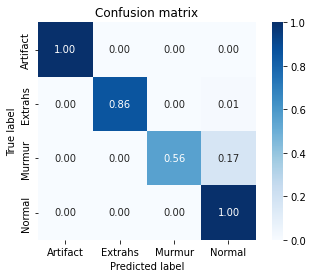

In [28]:
def show_confusion_matrix(confusion, test_labels):
  """Compute confusion matrix and normalize."""
  confusion_normalized = confusion.astype("float") / confusion.sum(axis=1)
  axis_labels = test_labels
  ax = sns.heatmap(
      confusion_normalized, xticklabels=axis_labels, yticklabels=axis_labels,
      cmap='Blues', annot=True, fmt='.2f', square=True)
  plt.title("Confusion matrix")
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

confusion_matrix = model.confusion_matrix(test_data)
show_confusion_matrix(confusion_matrix.numpy(), test_data.index_to_label)

In [14]:

help(model)


    

Help on AudioClassifier in module tensorflow_examples.lite.model_maker.core.task.audio_classifier object:

class AudioClassifier(tensorflow_examples.lite.model_maker.core.task.classification_model.ClassificationModel)
 |  AudioClassifier(model_spec, index_to_label, shuffle, train_whole_model)
 |  
 |  Audio classifier for training/inference and exporing.
 |  
 |  Method resolution order:
 |      AudioClassifier
 |      tensorflow_examples.lite.model_maker.core.task.classification_model.ClassificationModel
 |      tensorflow_examples.lite.model_maker.core.task.custom_model.CustomModel
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  confusion_matrix(self, data, batch_size=32)
 |  
 |  create_model(self, num_classes, train_whole_model)
 |  
 |  train(self, train_data, validation_data, epochs, batch_size)
 |  
 |  ----------------------------------------------------------------------
 |  Class methods defined here:
 |  
 |  create(train_data, model_spec, val

## Testing the model [Optional]

You can try the model on a sample audio from the test dataset just to see the results.

First you get the serving model.

In [15]:
serving_model = model.create_serving_model()

print(f'Model\'s input shape and type: {serving_model.inputs}')
print(f'Model\'s output shape and type: {serving_model.outputs}')

Model's input shape and type: [<KerasTensor: shape=(None, 15600) dtype=float32 (created by layer 'audio')>]
Model's output shape and type: [<KerasTensor: shape=(None, 521) dtype=float32 (created by layer 'keras_layer')>, <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'sequential')>]


Coming back to the random audio you loaded earlier

heart sound name: Murmur
heart sound code: Atraining_murmur


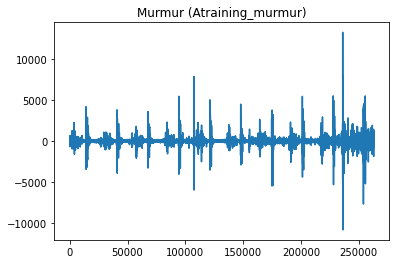

In [16]:
# if you want to try another file just uncoment the line below
random_audio = get_random_audio_file()
show_heart_data(random_audio)

The model created has a fixed input window. 

For a given audio file, you'll have to split it in windows of data of the expected size. The last window might need to be filled with zeros.

In [17]:
sample_rate, audio_data = wavfile.read(random_audio, 'rb')

audio_data = np.array(audio_data) / tf.int16.max
input_size = serving_model.input_shape[1]

splitted_audio_data = tf.signal.frame(audio_data, input_size, input_size, pad_end=True, pad_value=0)

print(f'Test audio path: {random_audio}')
print(f'Original size of the audio data: {len(audio_data)}')
print(f'Number of windows for inference: {len(splitted_audio_data)}')

Test audio path: .\audio_dataset\output\test\Atraining_murmur\201106141148.wav
Original size of the audio data: 263126
Number of windows for inference: 17


You'll loop over all the splitted audio and apply the model for each one of them.

The model you've just trained has 2 outputs: The original YAMNet's output and the one you've just trained. This is important because the real world environment is more complicated than just bird sounds. You can use the YAMNet's output to filter out non relevant audio, for example, on the birds use case, if YAMNet is not classifying Birds or Animals, this might show that the output from your model might have an irrelevant classification.


Below both outpus are printed to make it easier to understand their relation. Most of the mistakes that your model make are when YAMNet's prediction is not related to your domain (eg: birds).

In [18]:
print(random_audio)

results = []
print('Result of the window ith:  your model class -> score,  (spec class -> score)')
for i, data in enumerate(splitted_audio_data):
  yamnet_output, inference = serving_model(data)
  results.append(inference[0].numpy())
  result_index = tf.argmax(inference[0])
  spec_result_index = tf.argmax(yamnet_output[0])
  t = spec._yamnet_labels()[spec_result_index]
  result_str = f'Result of the window {i}: ' \
  f'\t{test_data.index_to_label[result_index]} -> {inference[0][result_index].numpy():.3f}, ' \
  f'\t({spec._yamnet_labels()[spec_result_index]} -> {yamnet_output[0][spec_result_index]:.3f})'
  print(result_str)


results_np = np.array(results)
mean_results = results_np.mean(axis=0)
result_index = mean_results.argmax()
print(f'Mean result: {test_data.index_to_label[result_index]} -> {mean_results[result_index]}')

.\audio_dataset\output\test\Atraining_murmur\201106141148.wav
Result of the window ith:  your model class -> score,  (spec class -> score)
Result of the window 0: 	Atraining_extrahls -> 0.595, 	(Heart sounds, heartbeat -> 0.881)
Result of the window 1: 	Atraining_artifact -> 0.721, 	(Silence -> 0.632)
Result of the window 2: 	Atraining_extrahls -> 0.310, 	(Rowboat, canoe, kayak -> 0.328)
Result of the window 3: 	Atraining_artifact -> 0.728, 	(Silence -> 0.402)
Result of the window 4: 	Btraining_extrastole -> 0.289, 	(Rowboat, canoe, kayak -> 0.214)
Result of the window 5: 	Atraining_artifact -> 0.724, 	(Silence -> 0.911)
Result of the window 6: 	Atraining_normal -> 0.595, 	(Heart sounds, heartbeat -> 0.625)
Result of the window 7: 	Atraining_extrahls -> 0.522, 	(Heart sounds, heartbeat -> 0.942)
Result of the window 8: 	Atraining_artifact -> 0.793, 	(Silence -> 0.455)
Result of the window 9: 	Atraining_extrahls -> 0.402, 	(Heart sounds, heartbeat -> 0.703)
Result of the window 10: 	Atr

## Exporting the model

The last step is exporting your model to be used on embedded devices or on the browser.

The `export` method export both formats for you.

In [19]:
models_path = './heart_models'
print(f'Exporing the TFLite model to {models_path}')

model.export(models_path, tflite_filename='heart_sound_model.tflite')

Exporing the TFLite model to ./heart_models
INFO:tensorflow:Assets written to: C:\Users\Jonathan\AppData\Local\Temp\tmpq8jtmdqc\assets


INFO:tensorflow:Assets written to: C:\Users\Jonathan\AppData\Local\Temp\tmpq8jtmdqc\assets


INFO:tensorflow:TensorFlow Lite model exported successfully: ./heart_models\heart_sound_model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./heart_models\heart_sound_model.tflite


You can also export the SavedModel version for serving or using on a Python environment.

In [ ]:
model.export(models_path, export_format=[mm.ExportFormat.SAVED_MODEL, mm.ExportFormat.LABEL])

## Next Steps

You did it.

Now your new model can be deployed on  mobile devices using [TFLite Audio Tasks API](https://www.tensorflow.org/lite/inference_with_metadata/task_library/overview).

You can also try the same process with your own data with different classes and here is the documentation for [Model Maker for Audio Classification](https://www.tensorflow.org/lite/api_docs/python/tflite_model_maker/audio_classifier).

This notebook is part of the [ODML Learning path: Customizing an Audio Model](https://codelabs.developers.google.com/codelabs/tflite-audio-classification-custom-model-android). If you need more information follow the rest of the codelabs to have a clear understanding on how to use Machine Learning for Audio Classification.

For more information about Model Maker for Audio Classification